In [14]:
import numpy as np
from spec_id import Iterative_stacking, Median_w_Error_cont, Median_w_Error, Oldest_galaxy
from vtl.Readfile import Readfile
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage.interpolation import rotate
from astropy.cosmology import Planck13 as cosmo
from astropy.io import ascii, fits
from astropy.table import Table
import grizli
from matplotlib import gridspec
from matplotlib.patches import Rectangle

# import rpy2
# import rpy2.robjects as robjects
# R = robjects.r
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [3]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631 and ids != 41148')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [14]:
goodss_rad = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodsn_rad = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()

In [18]:
Reff = []

for i in galDB.index:
    if galDB.gids[i][0] == 's':
        r = goodss_rad.re[goodss_rad.NUMBER == galDB.ids[i]].values * np.sqrt(goodss_rad.q[goodss_rad.NUMBER == galDB.ids[i]].values)
        Reff.append(r[0])
    if galDB.gids[i][0] == 'n':
        r = goodsn_rad.re[goodsn_rad.NUMBER == galDB.ids[i]].values * np.sqrt(goodsn_rad.q[goodsn_rad.NUMBER == galDB.ids[i]].values)
        Reff.append(r[0])
        

In [4]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_3.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

def Gen_grid_dust(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_dust.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [10]:
"""DATA"""

age_range = np.arange(0,3,0.05)

gmtlDB = galDB.query('ids != 14713 and ids != 38126 and ids != 40597')
ferrdb = pd.read_pickle('../data/Q_ferreras.pkl')

Pl_grid = Gen_grid(lzDB,'t')
Pm_grid = Gen_grid(mzDB,'t')
Ph_grid = Gen_grid(hzDB,'t')
Puh_grid = Gen_grid(uhzDB,'t')

Pl_grid_d = Gen_grid_dust(lzDB,'t')
Pm_grid_d = Gen_grid_dust(mzDB,'t')
Ph_grid_d = Gen_grid_dust(hzDB,'t')
Puh_grid_d = Gen_grid_dust(uhzDB,'t')

Pl,Px = Iterative_stacking(Pl_grid,age)
Pm,Px = Iterative_stacking(Pm_grid,age)
Ph,Px = Iterative_stacking(Ph_grid,age)
Puh,Px = Iterative_stacking(Puh_grid,age)

Pl_d,Px = Iterative_stacking(Pl_grid_d,age)
Pm_d,Px = Iterative_stacking(Pm_grid_d,age)
Ph_d,Px = Iterative_stacking(Ph_grid_d,age)
Puh_d,Px = Iterative_stacking(Puh_grid_d,age)

lmed,ller,lher=Median_w_Error_cont(Pl,Px)
mmed,mler,mher=Median_w_Error_cont(Pm,Px)
hmed,hler,hher=Median_w_Error_cont(Ph,Px)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,Px)

lmed_d,ller_d,lher_d=Median_w_Error_cont(Pl_d,Px)
mmed_d,mler_d,mher_d=Median_w_Error_cont(Pm_d,Px)
hmed_d,hler_d,hher_d=Median_w_Error_cont(Ph_d,Px)
uhmed_d,uhler_d,uhher_d=Median_w_Error_cont(Puh_d,Px)

lt=np.array(lzDB['tx_lwa'])
mt=np.array(mzDB['tx_lwa'])
ht=np.array(hzDB['tx_lwa'])
uht=np.array(uhzDB['tx_lwa'])
gmtlt=np.array(gmtlDB['tx_lwa'])

fumx,fumy=Readfile('../data/fumagalli_fig14.dat',0)
d,fverr=Readfile('../data/fumagalli_fig14_verr.dat',0)
fherr,d=Readfile('../data/fumagalli_fig14_herr.dat',0)

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])


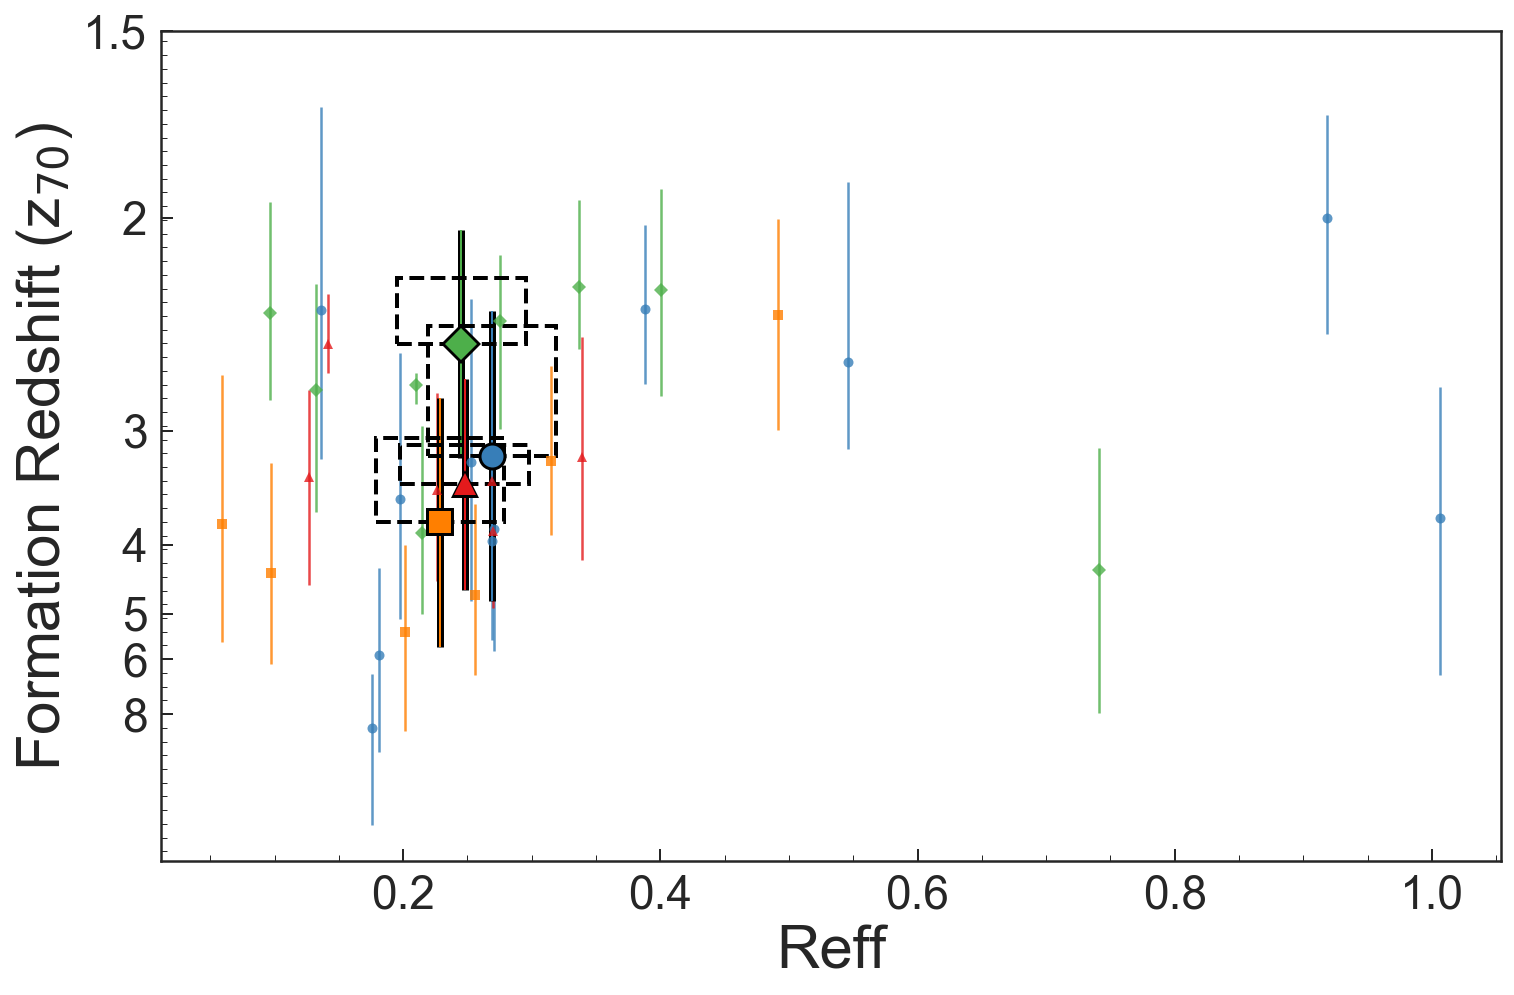

In [19]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
# plt.plot(z,ages,'k--',alpha=.5)

# plt.scatter(fumx[9], Oldest_galaxy(fumx[9]) - fumy[9],color = 'k',marker='^',label='Mendel+15',alpha=0.7)
# plt.scatter(fumx[10:14],Oldest_galaxy(fumx[10:14]) - fumy[10:14],color = 'k',marker='p',label='Choi+14',alpha=0.7)
# plt.scatter(fumx[14],Oldest_galaxy(fumx[14]) - fumy[14],color = 'k',marker='d',label='Gallazzi+14',alpha=0.7)
# plt.scatter(fumx[15],Oldest_galaxy(fumx[15]) - fumy[15],color = 'k',marker='*',label='Whitaker+13',alpha=0.7)
# plt.scatter(fumx[6:9],Oldest_galaxy(fumx[6:9]) - fumy[6:9],color='k',zorder=2,marker='s',label='Fumagalli+16',alpha=0.7)
# plt.scatter(ferrdb['z'],Oldest_galaxy(ferrdb['z'].values) - ferrdb['age'].values,color='k',zorder=2,marker='1',s=100,label='Ferreras+18',alpha=0.7)

plt.errorbar(lzDB['Reff'], Oldest_galaxy(lzDB['hi_res_specz']) - lt,
             yerr=[lzDB['tx_-_sig_lwa'],lzDB['tx_+_sig_lwa']],color='#377eb8',elinewidth=1.25,alpha=.8,ms=5,fmt='o')
plt.errorbar(mzDB['Reff'],Oldest_galaxy(mzDB['hi_res_specz']) - mt,
             yerr=[mzDB['tx_-_sig_lwa'],mzDB['tx_+_sig_lwa']],color='#4daf4a',elinewidth=1.25,alpha=.8,ms=5,fmt='D')
plt.errorbar(hzDB['Reff'],Oldest_galaxy(hzDB['hi_res_specz']) - ht,
             yerr=[hzDB['tx_-_sig_lwa'],hzDB['tx_+_sig_lwa']],color='#ff7f00',elinewidth=1.25,alpha=.8,ms=5,fmt='s')
plt.errorbar(uhzDB['Reff'],Oldest_galaxy(uhzDB['hi_res_specz']) - uht,
             yerr=[uhzDB['tx_-_sig_lwa'],uhzDB['tx_+_sig_lwa']],color='#e41a1c',elinewidth=1.25,alpha=.8,ms=5,fmt='^')
# plt.errorbar(1.758,Oldest_galaxy(1.758) - 1.6,
#             yerr=[[0.29],[1.07]],
#              color='k',elinewidth=1.25,ms=10,fmt='p',zorder=3, label='GSD41148')

plt.errorbar(np.median(lzDB['Reff']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='k',fmt='o',elinewidth=3.5,ms=14)
plt.errorbar(np.median(mzDB['Reff']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='k',fmt='D',elinewidth=3.5,ms=14)
plt.errorbar(np.median(hzDB['Reff']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='k',fmt='s',elinewidth=3.5,ms=14)
plt.errorbar(np.median(uhzDB['Reff']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='k',fmt='^',elinewidth=3.5,ms=14)

plt.errorbar(np.median(lzDB['Reff']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='#377eb8',elinewidth=1,ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['Reff']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='#4daf4a',elinewidth=1,ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['Reff']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='#ff7f00',elinewidth=1,ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['Reff']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='#e41a1c',elinewidth=1,ms=11,fmt='^',label='z~1.6')

currentAxis.add_patch(Rectangle((np.median(lzDB['Reff'])-0.05, 
                                 Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed)
                                ,0.1,lmed-lmed_d,fill=False ,edgecolor='k', zorder=2,
                                label='Dust Bound',linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(mzDB['Reff'])-0.05, 
                                 Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed)
                                ,0.1,mmed-mmed_d,fill=False ,edgecolor='k',zorder=2,linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(hzDB['Reff'])-0.05,
                                 Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed)
                                ,0.1,hmed-hmed_d,fill=False ,edgecolor='k',zorder=2,linewidth=2,linestyle='dashed'))
currentAxis.add_patch(Rectangle((np.median(uhzDB['Reff'])-0.05,
                                 Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed)
                                ,0.1,uhmed-uhmed_d,fill=False ,edgecolor='k', zorder=2,linewidth=2,linestyle='dashed'))

# handles, labels = currentAxis.get_legend_handles_labels()
# handles = np.array(handles)
# labels = np.array(labels)
# IDX = np.array([8,9,10,11,7,0,1,2,3,4,5,6])

plt.xlabel('Reff',size=30)
plt.ylabel('Formation Redshift (z$_{70}$)',size=30)
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,6,5,4,3,2,1.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.legend(handles[IDX], labels[IDX],loc=3,fontsize=15)


([<matplotlib.axis.YTick at 0x1a1f959128>,
 <a list of 7 Text yticklabel objects>)

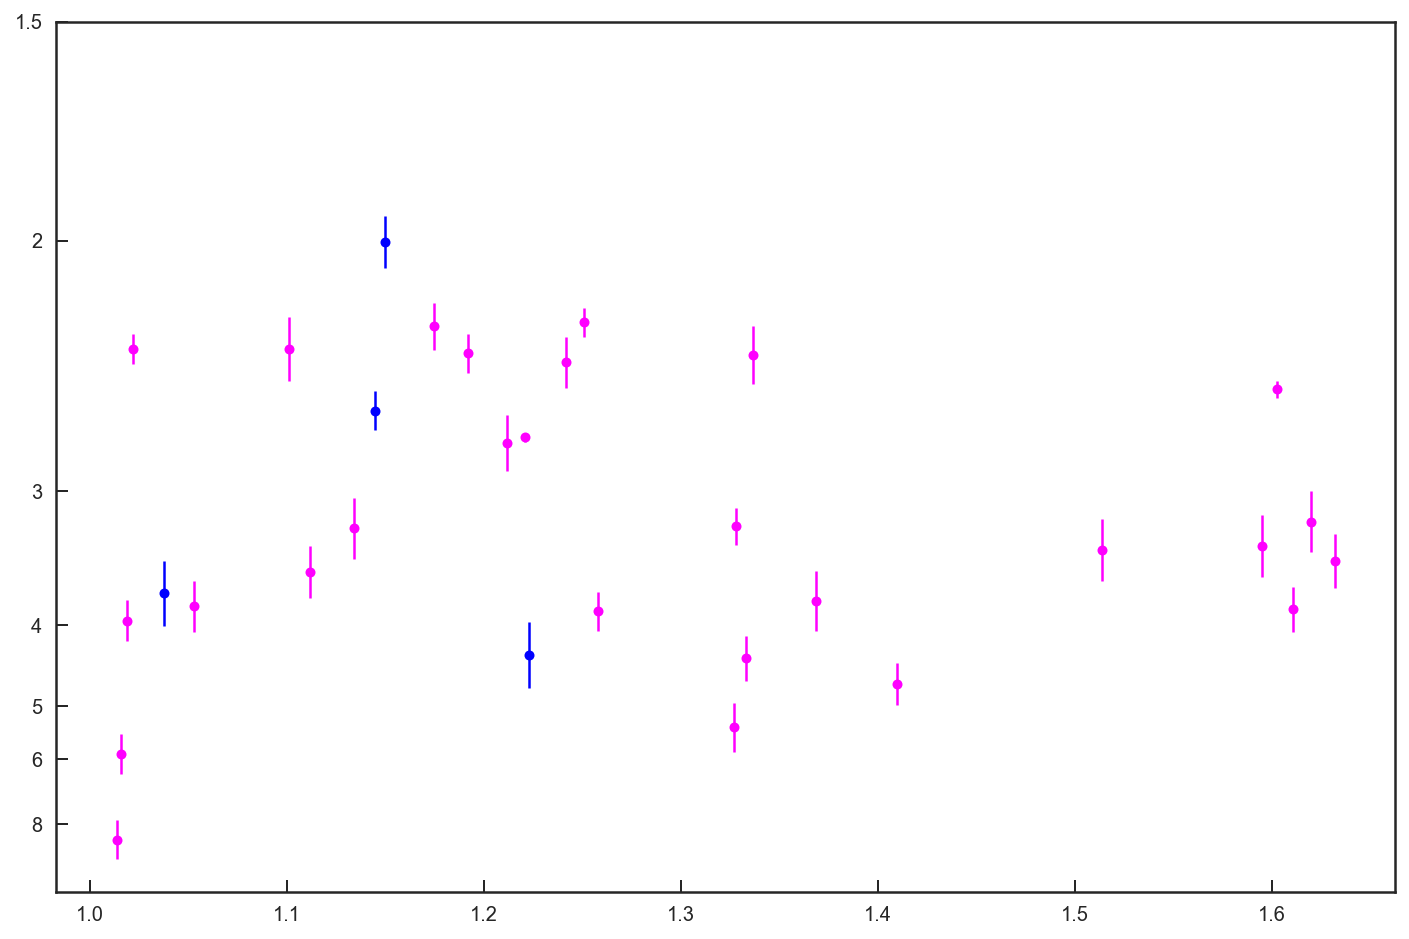

In [116]:
plt.figure(figsize=[12,8])

for i in galDB.index:
    if galDB.Reff[i] > 0.5:
        plt.errorbar(galDB['hi_res_specz'][i], Oldest_galaxy(galDB['hi_res_specz'][i]) - galDB['tx_lwa'][i],
    #     plt.errorbar(galDB['hi_res_specz'][i], galDB['tx_lwa'][i] / Oldest_galaxy(galDB['hi_res_specz'][i]),
                 yerr=[[galDB['tx_-_sig_lwa'][i]/ Oldest_galaxy(galDB['hi_res_specz'][i]),galDB['tx_+_sig_lwa'][i]/ Oldest_galaxy(galDB['hi_res_specz'][i])]],
                 color=[0,0,1],elinewidth=1.25,ms=5,fmt='o')    
    else:
        plt.errorbar(galDB['hi_res_specz'][i], Oldest_galaxy(galDB['hi_res_specz'][i]) - galDB['tx_lwa'][i],
    #     plt.errorbar(galDB['hi_res_specz'][i], galDB['tx_lwa'][i] / Oldest_galaxy(galDB['hi_res_specz'][i]),
                 yerr=[[galDB['tx_-_sig_lwa'][i]/ Oldest_galaxy(galDB['hi_res_specz'][i]),galDB['tx_+_sig_lwa'][i]/ Oldest_galaxy(galDB['hi_res_specz'][i])]],
                 color=[1,0,1],elinewidth=1.25,ms=5,fmt='o')
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,6,5,4,3,2,1.5])


([<matplotlib.axis.YTick at 0x1a20afaa58>,
 <a list of 7 Text yticklabel objects>)

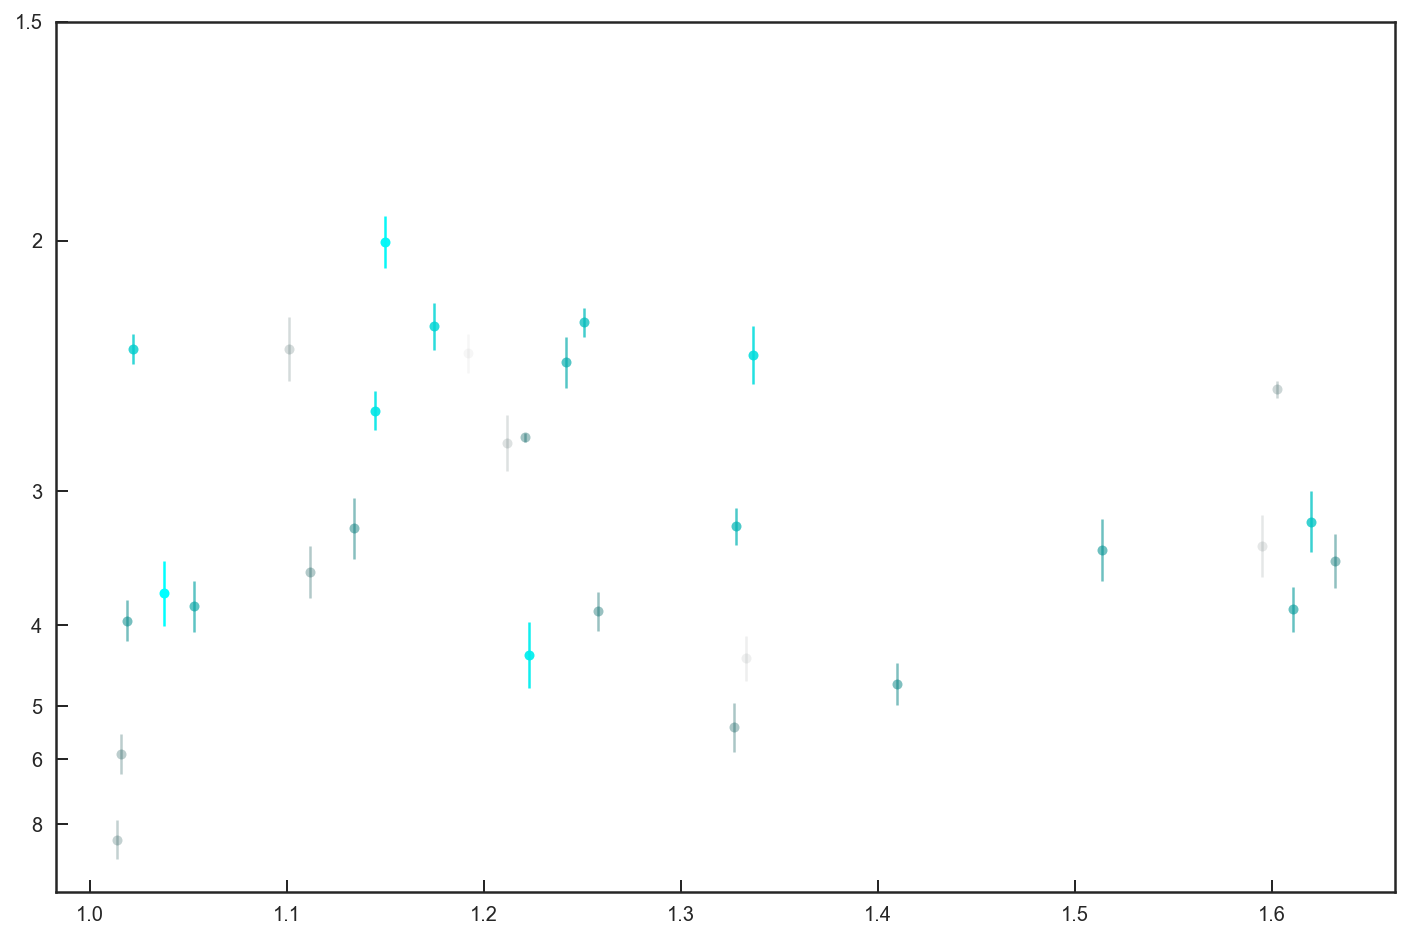

In [118]:
plt.figure(figsize=[12,8])

u=int(0)
for i in galDB.index:
    plt.errorbar(galDB['hi_res_specz'][i], Oldest_galaxy(galDB['hi_res_specz'][i]) - galDB['tx_lwa'][i],
    #     plt.errorbar(galDB['hi_res_specz'][i], galDB['tx_lwa'][i] / Oldest_galaxy(galDB['hi_res_specz'][i]),
            yerr=[[galDB['tx_-_sig_lwa'][i]/ Oldest_galaxy(galDB['hi_res_specz'][i]),galDB['tx_+_sig_lwa'][i]/ Oldest_galaxy(galDB['hi_res_specz'][i])]],
            color=[0,float(c[IDX[u]]) / c.max(),float(c[IDX[u]]) / c.max(), float(c[IDX[u]]) / c.max() ],elinewidth=1.25,ms=5,fmt='o')    
    u+=1
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,6,5,4,3,2,1.5])


In [67]:
c = np.arange(31)
sorted_r = np.sort(galDB.Reff)
uns_r = galDB.Reff.values

In [111]:
IDX=np.zeros(31).astype(int)
for i in range(len(uns_r)):
    IDX[i] = np.argwhere(sorted_r == uns_r[i])[0][0]


In [90]:
c.max()

30

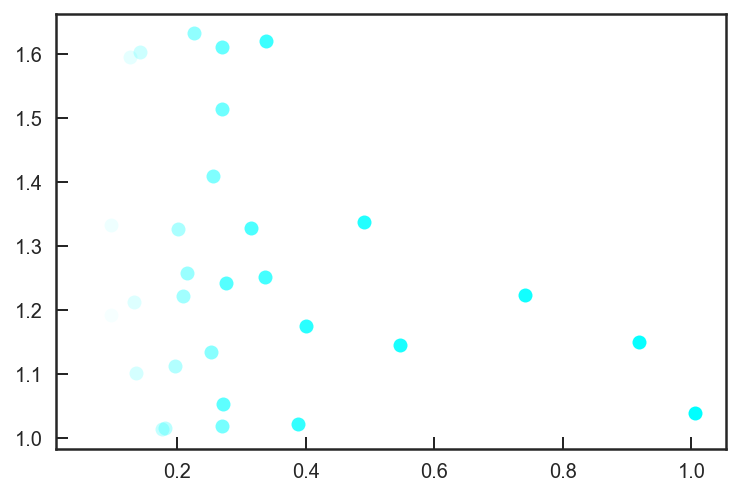

In [115]:
u=int(0)
for i in galDB.index:
    plt.errorbar(galDB['Reff'][i], galDB['hi_res_specz'][i],fmt = 'o',
            color=[0,1,1, float(c[IDX[u]]) / c.max()])  
    u+=1

In [110]:
galDB.Reff,uns_r

(49     0.176080
 50     0.096745
 58     0.136382
 61     0.336672
 62     0.269367
 69     0.252886
 86     0.918674
 96     0.546304
 107    0.214967
 212    0.741311
 217    0.400546
 219    0.226226
 220    0.387689
 221    0.269157
 223    0.271012
 224    0.097199
 225    0.275327
 227    0.126625
 228    0.132590
 230    0.209619
 231    0.255655
 232    0.314690
 235    0.141553
 236    0.338951
 246    0.181113
 248    0.269949
 251    0.491297
 258    1.006127
 259    0.201579
 260    0.059321
 267    0.197187
 Name: Reff, dtype: float64,
 array([0.17608018, 0.09674501, 0.136382  , 0.33667158, 0.26936736,
        0.25288604, 0.91867436, 0.54630444, 0.21496721, 0.7413108 ,
        0.40054572, 0.22622557, 0.38768897, 0.26915678, 0.27101225,
        0.09719878, 0.27532661, 0.12662484, 0.13258983, 0.20961925,
        0.25565506, 0.31469041, 0.1415529 , 0.3389511 , 0.181113  ,
        0.26994933, 0.49129722, 1.00612681, 0.20157946, 0.05932075,
        0.19718655]))